In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load the dataset

- Load the train data and using all your knowledge of pandas try to explore the different statistical properties of the dataset.

In [2]:
# Code starts here

# Load the train data
train = pd.read_csv('train.csv')

# Shape of the data
print('Shape of the train data is: ',train.shape)

print()

# Statistical properties of the data.
print('Statistical Properties of the train data are as follows: ')
print(train.describe())

Shape of the train data is:  (9072, 56)

Statistical Properties of the train data are as follows: 
                 Id    Elevation       Aspect        Slope  \
count   9072.000000  9072.000000  9072.000000  9072.000000   
mean    7535.450838  2749.531415   156.480930    16.529872   
std     4369.975238   417.236330   109.411024     8.495603   
min        1.000000  1863.000000     0.000000     0.000000   
25%     3739.500000  2375.750000    65.000000    10.000000   
50%     7551.500000  2755.000000   125.000000    15.000000   
75%    11325.250000  3099.000000   258.250000    22.000000   
max    15119.000000  3849.000000   360.000000    52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                       9072.000000                     9072.000000   
mean                         226.781966                       51.213624   
std                          208.875071                       61.621329   
min                            0.000000   


Skewness for the different features is as shown below: 
Elevation                              0.071829
Aspect                                 0.453036
Slope                                  0.536479
Horizontal_Distance_To_Hydrology       1.469340
Vertical_Distance_To_Hydrology         1.530355
Horizontal_Distance_To_Roadways        1.248358
Hillshade_9am                         -1.115988
Hillshade_Noon                        -0.961365
Hillshade_3pm                         -0.332192
Horizontal_Distance_To_Fire_Points     1.647477
Wilderness_Area1                       1.220795
Wilderness_Area2                       5.232999
Wilderness_Area3                       0.323882
Wilderness_Area4                       0.834809
Soil_Type1                             6.082981
Soil_Type2                             4.651335
Soil_Type3                             3.642825
Soil_Type4                             3.904306
Soil_Type5                             9.416832
Soil_Type6                     

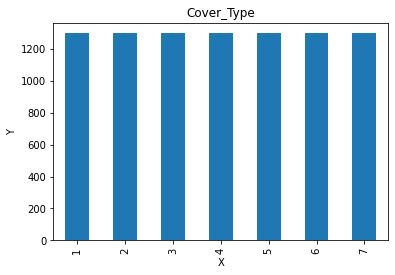

In [3]:
# Drop the Id.
train.drop('Id',axis=1,inplace=True)

# Checking for the class distribution of the target
train['Cover_Type'].value_counts().plot(kind='bar')
plt.title('Class Distribution of target')
plt.xlabel('Classes in target')
plt.ylabel('Distribution')

print()

# Checking for skewness in the features
print('Skewness for the different features is as shown below: ')
print(train.skew())

# Code ends here.

### EDA & Data Preprocessing

- The target is the only categorical feature consisting of 7 classes and all the other features are continuous. 
- Check out the best plots for plotting between categorical target and continuous features and try making some inferences from these plots. 

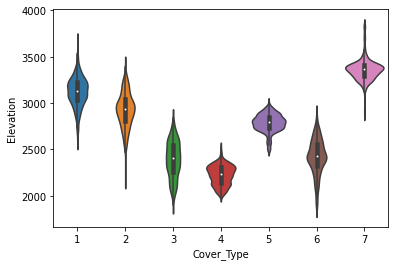

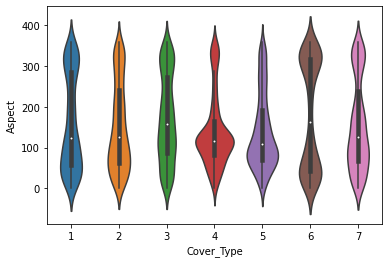

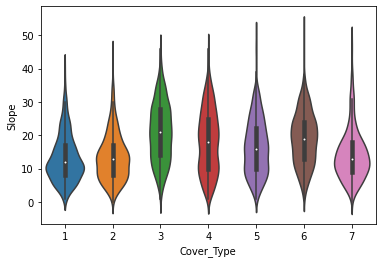

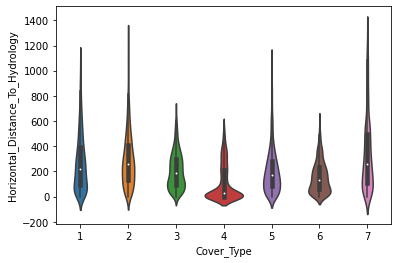

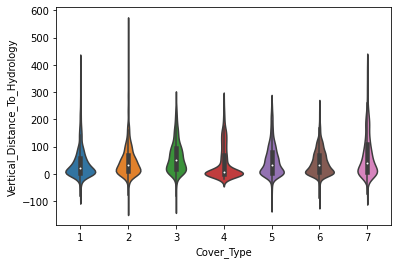

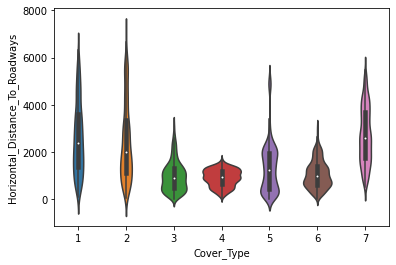

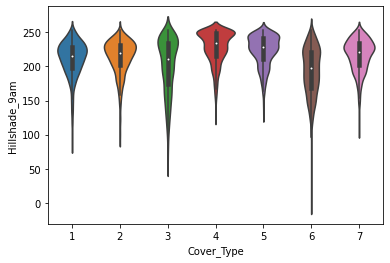

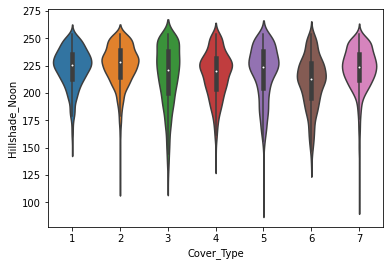

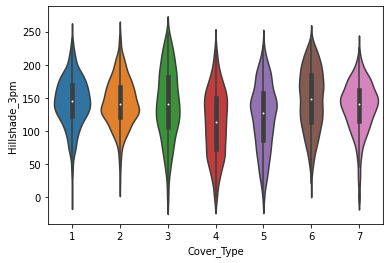

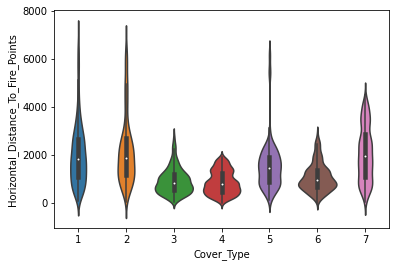

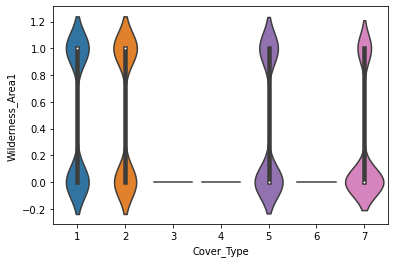

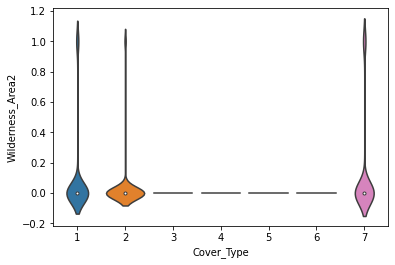

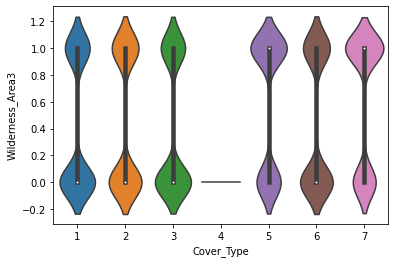

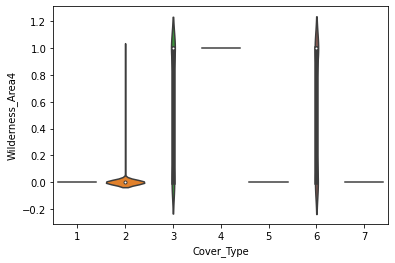

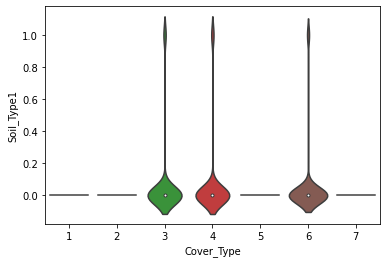

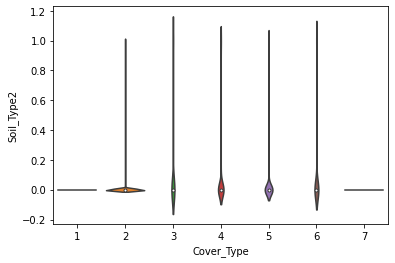

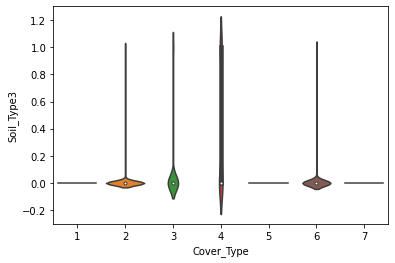

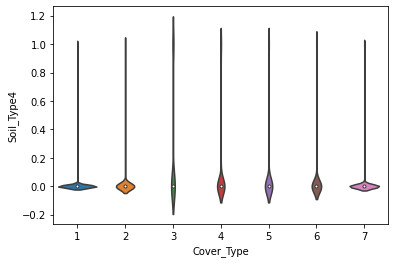

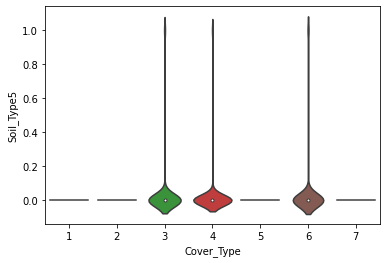

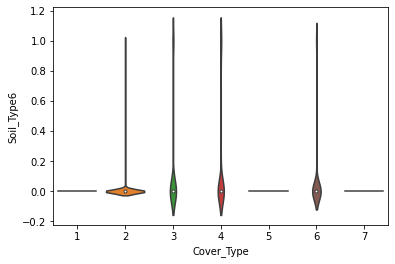

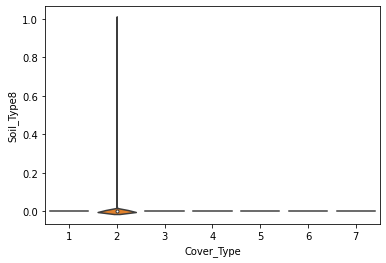

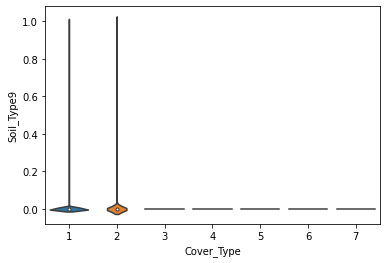

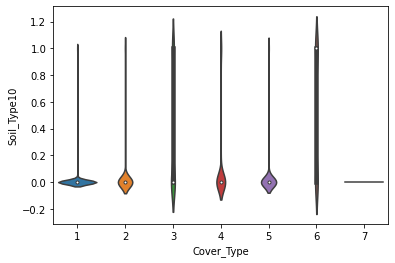

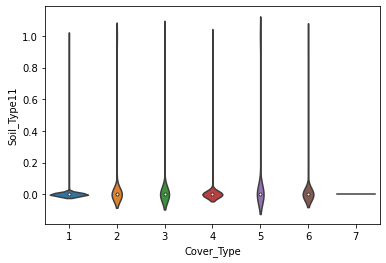

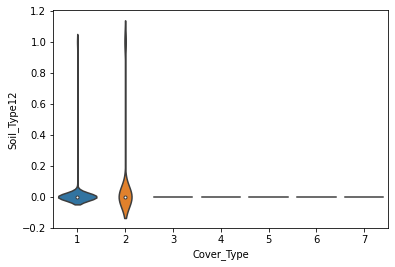

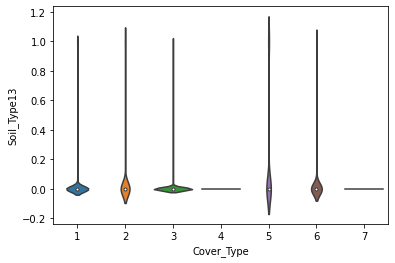

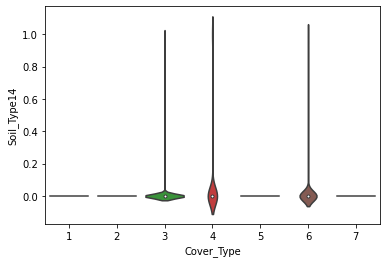

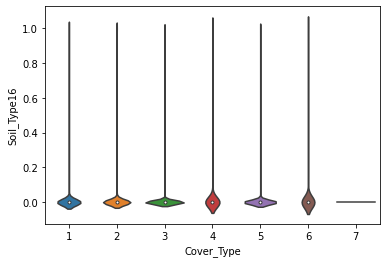

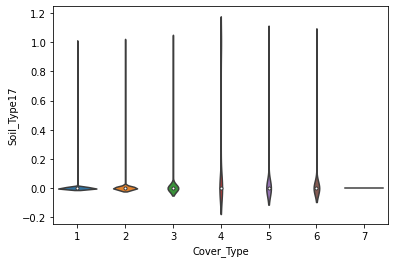

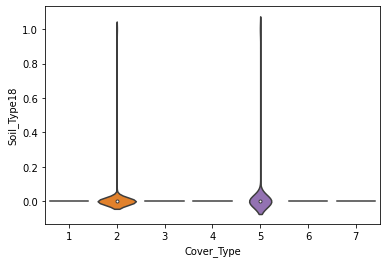

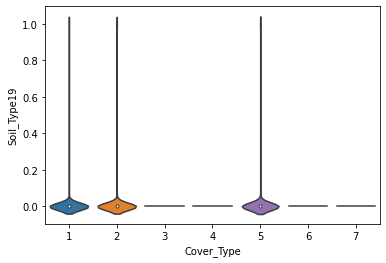

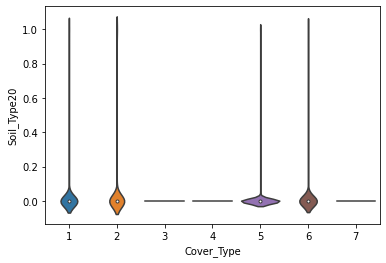

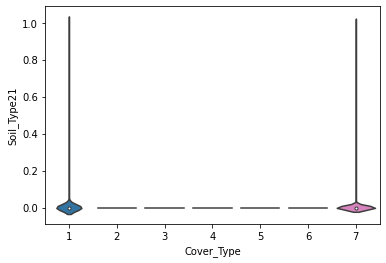

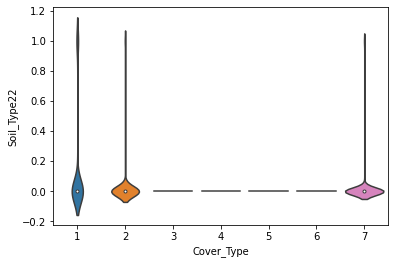

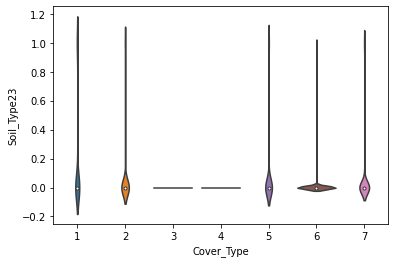

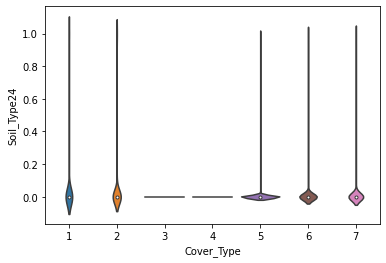

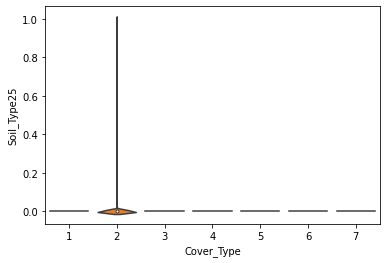

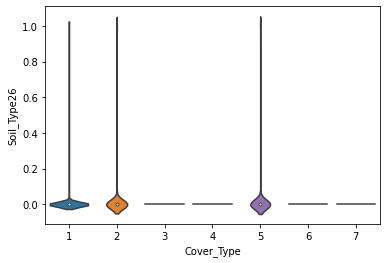

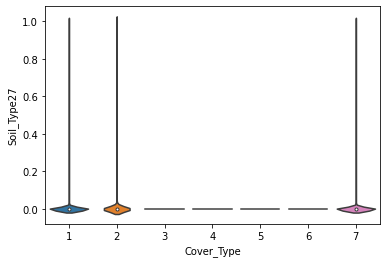

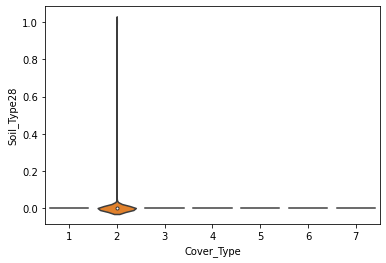

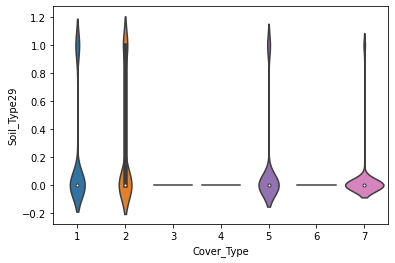

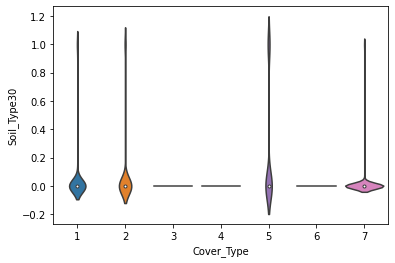

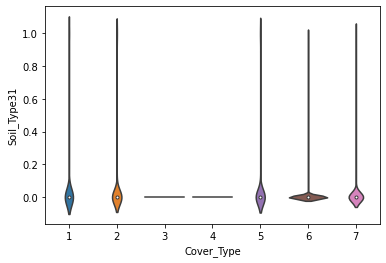

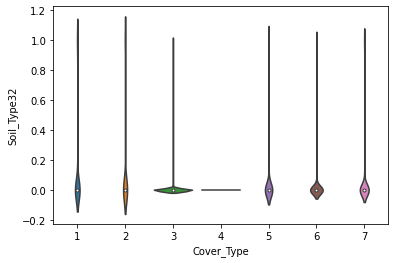

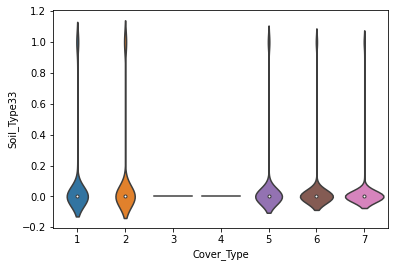

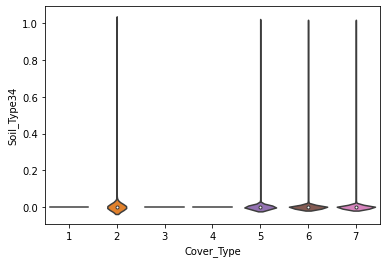

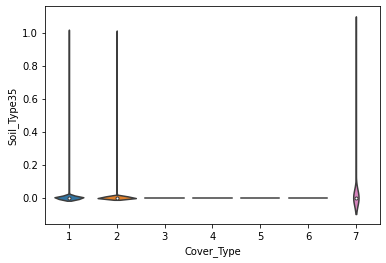

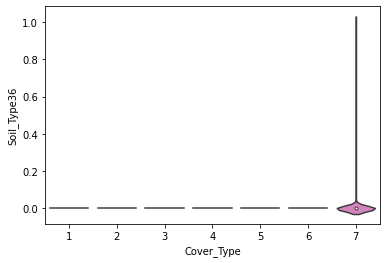

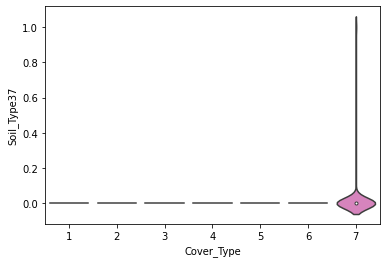

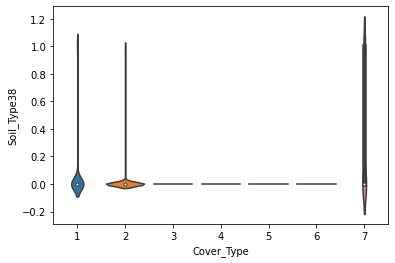

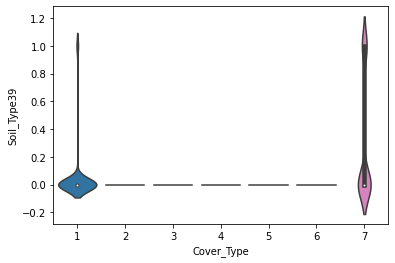

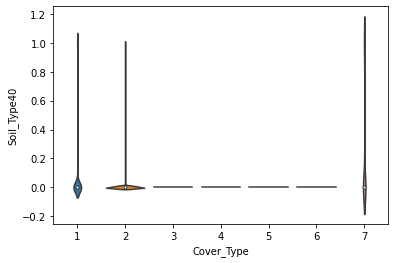

Elevation                         Wilderness_Area4                   -0.783816
Wilderness_Area4                  Elevation                          -0.783816
Hillshade_9am                     Hillshade_3pm                      -0.781940
Hillshade_3pm                     Hillshade_9am                      -0.781940
Slope                             Hillshade_Noon                     -0.610468
Hillshade_Noon                    Slope                              -0.610468
Hillshade_9am                     Aspect                             -0.593524
Aspect                            Hillshade_9am                      -0.593524
Wilderness_Area4                  Wilderness_Area3                   -0.567056
Wilderness_Area3                  Wilderness_Area4                   -0.567056
Wilderness_Area1                  Soil_Type29                         0.547484
Soil_Type29                       Wilderness_Area1                    0.547484
Elevation                         Horizontal_Distanc

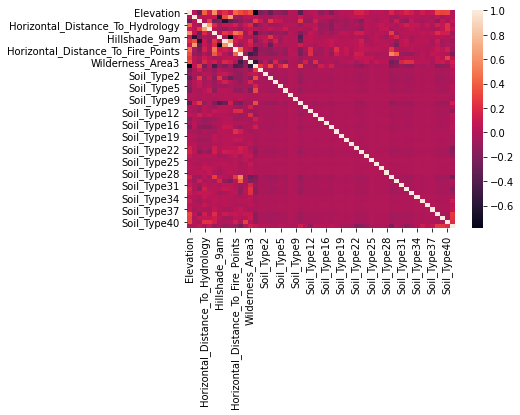

In [5]:
# Dropping the columns Soil_Type7 and Soil_Type15
train.drop(['Soil_Type7','Soil_Type15'],1,inplace=True)

# Plotting a violinplot between every feature and target
for i in range(0,len(train.columns)-1):
    sns.violinplot(data=train,x=train.iloc[:,-1],y=train[train.columns[i]])
    plt.show()
    
# Plotting a heatmap using to check for correlation between the features
sns.heatmap(train.corr())


# Selecting upper and lower threshold
upper_threshold = 0.5
lower_threshold = -0.5


# List the correlation pairs
correlation = train.corr().unstack().sort_values(kind='quicksort')

# Select the highest correlation pairs having correlation greater than upper threshold and lower than lower threshold
corr_var_list = correlation[((correlation>upper_threshold) | (correlation<lower_threshold)) & (correlation!=1)]
print(corr_var_list)

In [4]:
# Code starts here
# check correlation
corr=train.corr()

# print correlation
print(corr)
# Code ends here

                                    Elevation    Aspect     Slope  \
Elevation                            1.000000 -0.002747 -0.308519   
Aspect                              -0.002747  1.000000  0.024327   
Slope                               -0.308519  0.024327  1.000000   
Horizontal_Distance_To_Hydrology     0.404080  0.038210 -0.048597   
Vertical_Distance_To_Hydrology       0.122408  0.040190  0.265739   
Horizontal_Distance_To_Roadways      0.578398  0.072182 -0.278127   
Hillshade_9am                        0.095177 -0.593524 -0.204889   
Hillshade_Noon                       0.219430  0.335673 -0.610468   
Hillshade_3pm                        0.092541  0.638884 -0.320700   
Horizontal_Distance_To_Fire_Points   0.432142 -0.052493 -0.246151   
Wilderness_Area1                     0.333439 -0.118342 -0.159047   
Wilderness_Area2                     0.264110  0.033637 -0.064572   
Wilderness_Area3                     0.348913  0.030579 -0.101853   
Wilderness_Area4                  

### Feature Selection and Model building

- Separate the features and target and then split the train data into train and validation set.
- Apply different models of your choice and  then predict on the validation data and find the `accuracy_score` for this prediction.
- Try improving upon the `accuracy_score` using different feature selection techniques like wrapper methods, PCA and try using hyperparameter tuning to find the parameters that give the best accuracy.

In [6]:
# Code Starts here

# Code starts here
X = train.drop('Cover_Type',axis=1)

# store dependent variable
y = train['Cover_Type']

# Separate into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

# Fitting a Random Forest model on the train data and predict on the test data.
model = RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=4)
rfe = RFE(model, 42)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)
model.fit(X_train_rfe,y_train)
y_Pred_rfe = model.predict(X_test_rfe)
print(accuracy_score(y_test,y_Pred_rfe))

# Code ends here

0.8380165289256198


### Prediction on the test data and creating the sample submission file.

- Load the test data and store the `Id` column in a separate variable.
- Perform the same operations on the test data that you have performed on the train data.
- Create the submission file as a `csv` file consisting of the `Id` column from the test data and your prediction as the second column.

In [7]:
# Code starts here

# Prediction on test data

# Read the test data
test = pd.read_csv('test.csv')

# Storing the id from the test file
id_ = test['Id']

# Applying same transformation on test
test.drop(['Id','Soil_Type7','Soil_Type15'],1,inplace=True)

# Applying rfe on test data
test_rfe = rfe.transform(test)

# Predict on the test data
y_pred_test = model.predict(test_rfe)

# Create a sample submission file
sample_submission = pd.DataFrame({'Id':id_,'Cover_Type':y_pred_test})

# Convert the sample submission file into a csv file
sample_submission.to_csv('FCsubmission.csv',index=False)

# Code ends here